In [97]:
# =====================================================
# ✅ Colab 한글 폰트 완전 고정 템플릿 (자동 탐지·자동 선택)
# 런타임 세션 다시 시작후 코드 입력
# =====================================================
!apt-get update -qq > /dev/null
!apt-get install -y fonts-noto-cjk fonts-nanum > /dev/null
!fc-cache -fv > /dev/null

import os, glob, shutil
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1) matplotlib 폰트 캐시 폴더 보장 + 기존 캐시 파일 정리
cache_dir = os.path.join(os.path.expanduser("~"), ".cache", "matplotlib")
os.makedirs(cache_dir, exist_ok=True)
for f in glob.glob(os.path.join(cache_dir, "fontlist-*.json*")):
    try:
        os.remove(f)
    except FileNotFoundError:
        pass

# 2) 시스템 폰트 목록 새로 읽기
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')  # 있으면 등록
# (Noto CJK는 패키지 설치 시 자동 등록됨)

# 3) 사용 가능한 한글 폰트 자동 탐지
candidates = [
    "NanumGothic",
    "Noto Sans CJK KR",   # 권장
    "Noto Sans CJK",      # 일부 배포판에서 이 이름으로만 잡힐 수 있음
    "Noto Sans CJK SC",   # 혹시 중국어 패키지만 깔렸을 때 대체
]
available = {f.name for f in fm.fontManager.ttflist}
chosen = None
for name in candidates:
    if any(name == a or name in a for a in available):
        chosen = name
        break
if chosen is None:
    chosen = "DejaVu Sans"  # 최후의 안전장치(한글 미지원)

# 4) 전역 폰트 설정 (FontProperties 객체 사용 안 함 → TypeError 예방)
plt.rcParams.update({
    "font.family": chosen,
    "font.sans-serif": [chosen],
    "axes.unicode_minus": False,
    "font.size": 10,
})

print("✅ 사용 폰트:", chosen)
# 간단 테스트
plt.figure()
plt.title("한글 폰트 테스트: 고·중·저 연봉 그룹 (KR 포함) ✔")
plt.plot([0,1],[0,1])
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.tight_layout()
plt.show()

In [1]:
# 0) 라이브러리 불러오기
import pandas as pd
#
import numpy as np

# sklearn(사이크 런) - 러신러닝하는 라이브러리

from sklearn.model_selection import train_test_split
# 분할 - 데이터베이스 중 8:2 or 7:3 으로 분할 후 큰 데이터로 기계학습 후 작은 데이터로 스스로 검사(정확도 판별)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
#1) 데이터 로드

df = pd.read_csv("/content/ai_job_market.csv")

df.head()

,job_id,company_name,industry,job_title,skills_required,experience_level,employment_type,location,salary_range_usd,posted_date,company_size,tools_preferred
0,1,Foster and Sons,Healthcare,Data Analyst,"NumPy, Reinforcement Learning, PyTorch, Scikit...",Mid,Full-time,"Tracybury, AR",92860-109598,2025-08-20,Large,"KDB+, LangChain"
1,2,"Boyd, Myers and Ramirez",Tech,Computer Vision Engineer,"Scikit-learn, CUDA, SQL, Pandas",Senior,Full-time,"Lake Scott, CU",78523-144875,2024-03-22,Large,"FastAPI, KDB+, TensorFlow"
2,3,King Inc,Tech,Quant Researcher,"MLflow, FastAPI, Azure, PyTorch, SQL, GCP",Entry,Full-time,"East Paige, CM",124496-217204,2025-09-18,Large,"BigQuery, PyTorch, Scikit-learn"
3,4,"Cooper, Archer and Lynch",Tech,AI Product Manager,"Scikit-learn, C++, Pandas, LangChain, AWS, R",Mid,Full-time,"Perezview, FI",50908-123743,2024-05-08,Large,"TensorFlow, BigQuery, MLflow"
4,5,Hall LLC,Finance,Data Scientist,"Excel, Keras, SQL, Hugging Face",Senior,Contract,"North Desireeland, NE",98694-135413,2025-02-24,Large,"PyTorch, LangChain"


In [100]:
# 2) 분석에 쓸 열(컬럼)만 선택
#      - 타깃 : salary_range_usd 중 앞 숫자만 사용해 초봉으로 가정
#      - 입력 : industry, job_title, skills_required, experience_level, employment_type, location(국가만 사용), posted_date, company_size => 피쳐(feature)
use_cols = ["salary_range_usd", "industry", "job_title", "skills_required",
             "experience_level", "employment_type", "location", "posted_date", "company_size"]
df = df[use_cols].copy()

In [101]:
df.head()

,salary_range_usd,industry,job_title,skills_required,experience_level,employment_type,location,posted_date,company_size
0,92860-109598,Healthcare,Data Analyst,"NumPy, Reinforcement Learning, PyTorch, Scikit...",Mid,Full-time,"Tracybury, AR",2025-08-20,Large
1,78523-144875,Tech,Computer Vision Engineer,"Scikit-learn, CUDA, SQL, Pandas",Senior,Full-time,"Lake Scott, CU",2024-03-22,Large
2,124496-217204,Tech,Quant Researcher,"MLflow, FastAPI, Azure, PyTorch, SQL, GCP",Entry,Full-time,"East Paige, CM",2025-09-18,Large
3,50908-123743,Tech,AI Product Manager,"Scikit-learn, C++, Pandas, LangChain, AWS, R",Mid,Full-time,"Perezview, FI",2024-05-08,Large
4,98694-135413,Finance,Data Scientist,"Excel, Keras, SQL, Hugging Face",Senior,Contract,"North Desireeland, NE",2025-02-24,Large


In [102]:
# 전처리 작업

In [103]:
# 3) 결측치 처리 (현재는 없으므로 패스)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   salary_range_usd  2000 non-null   object
 1   industry          2000 non-null   object
 2   job_title         2000 non-null   object
 3   skills_required   2000 non-null   object
 4   experience_level  2000 non-null   object
 5   employment_type   2000 non-null   object
 6   location          2000 non-null   object
 7   posted_date       2000 non-null   object
 8   company_size      2000 non-null   object
dtypes: object(9)
memory usage: 140.8+ KB


In [105]:
# experience_level : 원-핫 인코딩(가장 쉬운 방법)
# drop_first=True로 더미 변수 함정 피하기(열 하나 줄이기)
experience_level_dum = pd.get_dummies(df["experience_level"], prefix="experience_level", drop_first=True)
df = pd.concat([df.drop(columns=["experience_level"]), experience_level_dum], axis=1)

In [106]:
df

,salary_range_usd,industry,job_title,skills_required,employment_type,location,posted_date,company_size,experience_level_Mid,experience_level_Senior
0,92860-109598,Healthcare,Data Analyst,"NumPy, Reinforcement Learning, PyTorch, Scikit...",Full-time,"Tracybury, AR",2025-08-20,Large,True,False
1,78523-144875,Tech,Computer Vision Engineer,"Scikit-learn, CUDA, SQL, Pandas",Full-time,"Lake Scott, CU",2024-03-22,Large,False,True
2,124496-217204,Tech,Quant Researcher,"MLflow, FastAPI, Azure, PyTorch, SQL, GCP",Full-time,"East Paige, CM",2025-09-18,Large,False,False
3,50908-123743,Tech,AI Product Manager,"Scikit-learn, C++, Pandas, LangChain, AWS, R",Full-time,"Perezview, FI",2024-05-08,Large,True,False
4,98694-135413,Finance,Data Scientist,"Excel, Keras, SQL, Hugging Face",Contract,"North Desireeland, NE",2025-02-24,Large,False,True
...,...,...,...,...,...,...,...,...,...,...
1995,90382-110126,Finance,NLP Engineer,"Flask, FastAPI, Power BI",Internship,"Washingtonmouth, SD",2024-04-22,Large,False,True
1996,47848-137195,Automotive,AI Product Manager,"R, Flask, Excel, C++, CUDA, Scikit-learn",Remote,"Joshuafort, ZA",2023-12-02,Large,True,False
1997,134994-180108,Education,Data Analyst,"Hugging Face, Excel, Scikit-learn, R, MLflow",Contract,"West Brittanyburgh, CG",2023-10-29,Large,False,False
1998,62388-82539,Education,Quant Researcher,"AWS, Python, Scikit-learn",Contract,"Anthonyshire, OM",2024-08-10,Large,False,True


In [107]:
# employment_type : 원-핫 인코딩(가장 쉬운 방법)
# drop_first=True로 더미 변수 함정 피하기(열 하나 줄이기)
employment_type_dum = pd.get_dummies(df["employment_type"], prefix="employment_type", drop_first=True)
df = pd.concat([df.drop(columns=["employment_type"]), employment_type_dum], axis=1)

# company_size : 원-핫 인코딩(가장 쉬운 방법)
# drop_first=True로 더미 변수 함정 피하기(열 하나 줄이기)
company_size_dum = pd.get_dummies(df["company_size"], prefix="company_size", drop_first=True)
df = pd.concat([df.drop(columns=["company_size"]), company_size_dum], axis=1)

# drop_first=True로 더미 변수 함정 피하기(열 하나 줄이기)
industry_dum = pd.get_dummies(df["industry"], prefix="industry", drop_first=True)
df = pd.concat([df.drop(columns=["industry"]), industry_dum], axis=1)

# drop_first=True로 더미 변수 함정 피하기(열 하나 줄이기)
job_title_dum = pd.get_dummies(df["job_title"], prefix="job_title", drop_first=True)
df = pd.concat([df.drop(columns=["job_title"]), job_title_dum], axis=1)

In [108]:
df

,salary_range_usd,skills_required,location,posted_date,experience_level_Mid,experience_level_Senior,employment_type_Full-time,employment_type_Internship,employment_type_Remote,company_size_Mid,...,industry_Healthcare,industry_Retail,industry_Tech,job_title_AI Researcher,job_title_Computer Vision Engineer,job_title_Data Analyst,job_title_Data Scientist,job_title_ML Engineer,job_title_NLP Engineer,job_title_Quant Researcher
0,92860-109598,"NumPy, Reinforcement Learning, PyTorch, Scikit...","Tracybury, AR",2025-08-20,True,False,True,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1,78523-144875,"Scikit-learn, CUDA, SQL, Pandas","Lake Scott, CU",2024-03-22,False,True,True,False,False,False,...,False,False,True,False,True,False,False,False,False,False
2,124496-217204,"MLflow, FastAPI, Azure, PyTorch, SQL, GCP","East Paige, CM",2025-09-18,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
3,50908-123743,"Scikit-learn, C++, Pandas, LangChain, AWS, R","Perezview, FI",2024-05-08,True,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,98694-135413,"Excel, Keras, SQL, Hugging Face","North Desireeland, NE",2025-02-24,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,90382-110126,"Flask, FastAPI, Power BI","Washingtonmouth, SD",2024-04-22,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1996,47848-137195,"R, Flask, Excel, C++, CUDA, Scikit-learn","Joshuafort, ZA",2023-12-02,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1997,134994-180108,"Hugging Face, Excel, Scikit-learn, R, MLflow","West Brittanyburgh, CG",2023-10-29,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1998,62388-82539,"AWS, Python, Scikit-learn","Anthonyshire, OM",2024-08-10,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [109]:
# True/False → 1/0 변환
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)
df

,salary_range_usd,skills_required,location,posted_date,experience_level_Mid,experience_level_Senior,employment_type_Full-time,employment_type_Internship,employment_type_Remote,company_size_Mid,...,industry_Healthcare,industry_Retail,industry_Tech,job_title_AI Researcher,job_title_Computer Vision Engineer,job_title_Data Analyst,job_title_Data Scientist,job_title_ML Engineer,job_title_NLP Engineer,job_title_Quant Researcher
0,92860-109598,"NumPy, Reinforcement Learning, PyTorch, Scikit...","Tracybury, AR",2025-08-20,1,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,78523-144875,"Scikit-learn, CUDA, SQL, Pandas","Lake Scott, CU",2024-03-22,0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,124496-217204,"MLflow, FastAPI, Azure, PyTorch, SQL, GCP","East Paige, CM",2025-09-18,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,50908-123743,"Scikit-learn, C++, Pandas, LangChain, AWS, R","Perezview, FI",2024-05-08,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,98694-135413,"Excel, Keras, SQL, Hugging Face","North Desireeland, NE",2025-02-24,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,90382-110126,"Flask, FastAPI, Power BI","Washingtonmouth, SD",2024-04-22,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1996,47848-137195,"R, Flask, Excel, C++, CUDA, Scikit-learn","Joshuafort, ZA",2023-12-02,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1997,134994-180108,"Hugging Face, Excel, Scikit-learn, R, MLflow","West Brittanyburgh, CG",2023-10-29,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1998,62388-82539,"AWS, Python, Scikit-learn","Anthonyshire, OM",2024-08-10,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [110]:
# 예시: skills_required가 문자열 형태로 되어 있는 경우
# (이미 df에 이 컬럼이 포함되어 있다고 가정)
# 예: "Python, SQL, Excel"

# 1️⃣ 문자열을 리스트로 변환
df['skills_list'] = df['skills_required'].fillna('').apply(
    lambda x: [s.strip() for s in x.split(',') if s.strip() != '']
)

# 2️⃣ 모든 스킬 집합 추출
all_skills = sorted(set(sum(df['skills_list'], [])))  # 중복 제거 후 정렬

print(f"총 {len(all_skills)}개 스킬 발견")

# 3️⃣ 각 스킬별로 0/1 인코딩
for skill in all_skills:
    df[skill] = df['skills_list'].apply(lambda skills: int(skill in skills))

# 2️⃣ 원본 문자열 컬럼 제거
df = df.drop(columns=['skills_required', 'skills_list'])

# 4️⃣ 결과 확인
print(df[all_skills].head())

총 22개 스킬 발견
   AWS  Azure  C++  CUDA  Excel  FastAPI  Flask  GCP  Hugging Face  Keras  \
0    0      0    0     0      0        1      0    1             0      0   
1    0      0    0     1      0        0      0    0             0      0   
2    0      1    0     0      0        1      0    1             0      0   
3    1      0    1     0      0        0      0    0             0      0   
4    0      0    0     0      1        0      0    0             1      1   

   ...  NumPy  Pandas  Power BI  PyTorch  Python  R  Reinforcement Learning  \
0  ...      1       0         0        1       0  0                       1   
1  ...      0       1         0        0       0  0                       0   
2  ...      0       0         0        1       0  0                       0   
3  ...      0       1         0        0       0  1                       0   
4  ...      0       0         0        0       0  0                       0   

   SQL  Scikit-learn  TensorFlow  
0    0         

In [111]:
df

,salary_range_usd,location,posted_date,experience_level_Mid,experience_level_Senior,employment_type_Full-time,employment_type_Internship,employment_type_Remote,company_size_Mid,company_size_Startup,...,NumPy,Pandas,Power BI,PyTorch,Python,R,Reinforcement Learning,SQL,Scikit-learn,TensorFlow
0,92860-109598,"Tracybury, AR",2025-08-20,1,0,1,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
1,78523-144875,"Lake Scott, CU",2024-03-22,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
2,124496-217204,"East Paige, CM",2025-09-18,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,50908-123743,"Perezview, FI",2024-05-08,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,98694-135413,"North Desireeland, NE",2025-02-24,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,90382-110126,"Washingtonmouth, SD",2024-04-22,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1996,47848-137195,"Joshuafort, ZA",2023-12-02,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1997,134994-180108,"West Brittanyburgh, CG",2023-10-29,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1998,62388-82539,"Anthonyshire, OM",2024-08-10,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [112]:
# 날짜 변환
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')

# 연도, 월, 일 분리
df['posted_year'] = df['posted_date'].dt.year
df['posted_month'] = df['posted_date'].dt.month

df = df.drop(columns=['posted_date'])

In [113]:
df

,salary_range_usd,location,experience_level_Mid,experience_level_Senior,employment_type_Full-time,employment_type_Internship,employment_type_Remote,company_size_Mid,company_size_Startup,industry_E-commerce,...,Power BI,PyTorch,Python,R,Reinforcement Learning,SQL,Scikit-learn,TensorFlow,posted_year,posted_month
0,92860-109598,"Tracybury, AR",1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,1,0,2025,8
1,78523-144875,"Lake Scott, CU",0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,2024,3
2,124496-217204,"East Paige, CM",0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,2025,9
3,50908-123743,"Perezview, FI",1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,2024,5
4,98694-135413,"North Desireeland, NE",0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2025,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,90382-110126,"Washingtonmouth, SD",0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,2024,4
1996,47848-137195,"Joshuafort, ZA",1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,2023,12
1997,134994-180108,"West Brittanyburgh, CG",0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,2023,10
1998,62388-82539,"Anthonyshire, OM",0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,2024,8


In [114]:
# salary_range_usd에서 '-' 앞부분만 추출
df['salary_range_usd'] = df['salary_range_usd'].astype(str)

df['salary_range_usd'] = df['salary_range_usd'].apply(
    lambda x: x.split('-')[0].strip() if '-' in x else x.strip()
)

# 숫자로 변환 (선택사항)
df['salary_range_usd'] = pd.to_numeric(df['salary_range_usd'], errors='coerce')

# 결과 확인
print(df[['salary_range_usd']].head(10))

   salary_range_usd
0             92860
1             78523
2            124496
3             50908
4             98694
5             92632
6             70575
7             63032
8            134239
9             79361


In [115]:
df

,salary_range_usd,location,experience_level_Mid,experience_level_Senior,employment_type_Full-time,employment_type_Internship,employment_type_Remote,company_size_Mid,company_size_Startup,industry_E-commerce,...,Power BI,PyTorch,Python,R,Reinforcement Learning,SQL,Scikit-learn,TensorFlow,posted_year,posted_month
0,92860,"Tracybury, AR",1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,1,0,2025,8
1,78523,"Lake Scott, CU",0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,2024,3
2,124496,"East Paige, CM",0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,2025,9
3,50908,"Perezview, FI",1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,2024,5
4,98694,"North Desireeland, NE",0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2025,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,90382,"Washingtonmouth, SD",0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,2024,4
1996,47848,"Joshuafort, ZA",1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,2023,12
1997,134994,"West Brittanyburgh, CG",0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,2023,10
1998,62388,"Anthonyshire, OM",0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,2024,8


In [116]:
# # location 컬럼에서 마지막 부분(국가 코드) 추출
# df['country_code'] = df['location'].astype(str).apply(
#     lambda x: x.split(',')[-1].strip() if ',' in x else np.nan
# )

# print(df[['location', 'country_code']].head(10))

# df = pd.get_dummies(df, columns=['country_code'], prefix='country')
df = df.drop(columns=['location'])

In [117]:
df

,salary_range_usd,experience_level_Mid,experience_level_Senior,employment_type_Full-time,employment_type_Internship,employment_type_Remote,company_size_Mid,company_size_Startup,industry_E-commerce,industry_Education,...,Power BI,PyTorch,Python,R,Reinforcement Learning,SQL,Scikit-learn,TensorFlow,posted_year,posted_month
0,92860,1,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,2025,8
1,78523,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,2024,3
2,124496,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,2025,9
3,50908,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,2024,5
4,98694,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2025,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,90382,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,2024,4
1996,47848,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,2023,12
1997,134994,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,2023,10
1998,62388,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,2024,8


In [118]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   salary_range_usd                    2000 non-null   int64
 1   experience_level_Mid                2000 non-null   int64
 2   experience_level_Senior             2000 non-null   int64
 3   employment_type_Full-time           2000 non-null   int64
 4   employment_type_Internship          2000 non-null   int64
 5   employment_type_Remote              2000 non-null   int64
 6   company_size_Mid                    2000 non-null   int64
 7   company_size_Startup                2000 non-null   int64
 8   industry_E-commerce                 2000 non-null   int64
 9   industry_Education                  2000 non-null   int64
 10  industry_Finance                    2000 non-null   int64
 11  industry_Healthcare                 2000 non-null   int64
 12  indust

,salary_range_usd,experience_level_Mid,experience_level_Senior,employment_type_Full-time,employment_type_Internship,employment_type_Remote,company_size_Mid,company_size_Startup,industry_E-commerce,industry_Education,...,Power BI,PyTorch,Python,R,Reinforcement Learning,SQL,Scikit-learn,TensorFlow,posted_year,posted_month
0,92860,1,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,2025,8
1,78523,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,2024,3
2,124496,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,2025,9
3,50908,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,2024,5
4,98694,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2025,2


In [119]:
# 현재 df를 CSV 파일로 저장
df.to_csv("ai_job_market_preprocessed.csv", index=False, encoding="utf-8-sig")


In [120]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 타깃 및 피처 분리
X = df.drop(columns=['salary_range_usd'])
y = np.log1p(df['salary_range_usd'])  # 로그 변환 안정화

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 예측
y_pred = rf.predict(X_test)

# 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


RMSE: 0.377
R²: -0.017


In [121]:
df = pd.read_csv("ai_job_market_preprocessed.csv")
df.head()

,salary_range_usd,experience_level_Mid,experience_level_Senior,employment_type_Full-time,employment_type_Internship,employment_type_Remote,company_size_Mid,company_size_Startup,industry_E-commerce,industry_Education,...,Power BI,PyTorch,Python,R,Reinforcement Learning,SQL,Scikit-learn,TensorFlow,posted_year,posted_month
0,92860,1,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,2025,8
1,78523,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,2024,3
2,124496,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,2025,9
3,50908,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,2024,5
4,98694,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2025,2


In [122]:
df = df.drop(columns=['country', 'country_code'], errors='ignore')
df

,salary_range_usd,experience_level_Mid,experience_level_Senior,employment_type_Full-time,employment_type_Internship,employment_type_Remote,company_size_Mid,company_size_Startup,industry_E-commerce,industry_Education,...,Power BI,PyTorch,Python,R,Reinforcement Learning,SQL,Scikit-learn,TensorFlow,posted_year,posted_month
0,92860,1,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,2025,8
1,78523,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,2024,3
2,124496,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,2025,9
3,50908,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,2024,5
4,98694,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2025,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,90382,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,2024,4
1996,47848,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,2023,12
1997,134994,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,2023,10
1998,62388,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,2024,8


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   salary_range_usd                    2000 non-null   int64
 1   experience_level_Mid                2000 non-null   int64
 2   experience_level_Senior             2000 non-null   int64
 3   employment_type_Full-time           2000 non-null   int64
 4   employment_type_Internship          2000 non-null   int64
 5   employment_type_Remote              2000 non-null   int64
 6   company_size_Mid                    2000 non-null   int64
 7   company_size_Startup                2000 non-null   int64
 8   industry_E-commerce                 2000 non-null   int64
 9   industry_Education                  2000 non-null   int64
 10  industry_Finance                    2000 non-null   int64
 11  industry_Healthcare                 2000 non-null   int64
 12  indust

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 타깃 및 피처 분리
X = df.drop(columns=['salary_range_usd'])
y = np.log1p(df['salary_range_usd'])  # 로그 변환 안정화

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 예측
y_pred = rf.predict(X_test)

# 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


RMSE: 0.377
R²: -0.017


In [125]:
# ======================================
#  Colab 전용 급여 예측 모델 (기본형)
# ======================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as sklearn_mse, r2_score
from lightgbm import LGBMRegressor

# 1. 데이터 로드
df = pd.read_csv("/content/ai_job_market_preprocessed.csv")

# 2. 피처 구성
feature_cols = [c for c in df.columns if c.startswith(('experience_level_', 'employment_type_', 'industry_', 'skill_'))]
target_col = 'salary_range_usd'

X = df[feature_cols].astype(float)   # numpy 2.x 호환 안전조치
y = df[target_col].astype(float)

# 3. 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 모델 학습
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

# 5. 예측 및 평가
preds = model.predict(X_test)

# ✅ 호환성 보장 버전 (직접 루트 사용)
rmse = np.sqrt(sklearn_mse(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²: {r2:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 11
[LightGBM] [Info] Start training from score 95654.005625
✅ RMSE: 33964.88
✅ R²: -0.0890


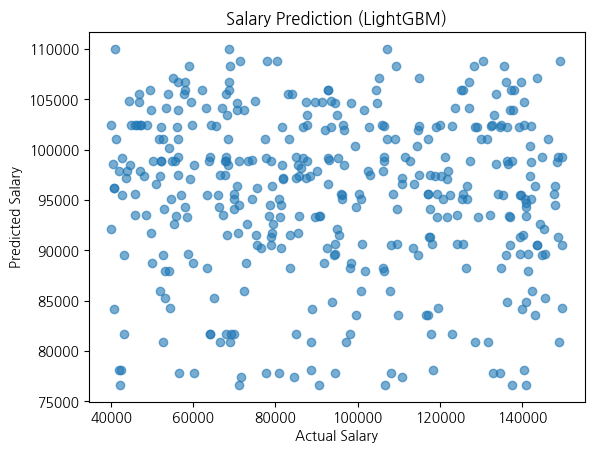

In [126]:
import matplotlib.pyplot as plt
plt.scatter(y_test, preds, alpha=0.6)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Salary Prediction (LightGBM)")
plt.show()

In [127]:
import sklearn, lightgbm, numpy, pandas
print(sklearn.__version__, lightgbm.__version__, numpy.__version__, pandas.__version__)


1.6.1 4.6.0 2.0.2 2.2.2


In [128]:
import inspect
print(metrics.mean_squared_error.__module__)
print(inspect.getfile(metrics.mean_squared_error))


sklearn.metrics._regression
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py


In [129]:
# 1. 라이브러리
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 2. 데이터 준비
df = pd.read_csv("/content/ai_job_market_preprocessed.csv")

# 3. 입력(X)과 타깃(y)
target_col = "salary_range_usd"
X = df.drop(columns=[target_col])
y = df[target_col]

# 4. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. 모델 정의
model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.85,
    random_state=42
)

# 6. 모델 학습
model.fit(X_train, y_train)

# 7. 예측
y_pred = model.predict(X_test)

# 8. 평가 지표
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 44
[LightGBM] [Info] Start training from score 95654.005625
RMSE: 36,934.33
R² Score: -0.2877


In [130]:
skill_cols = [c for c in df.columns if c.startswith("skill_")]
print("Skill 컬럼 개수:", len(skill_cols))
print(skill_cols[:10])
print(df[skill_cols].dtypes.value_counts())

Skill 컬럼 개수: 0
[]
Series([], Name: count, dtype: int64)


/tmp/ipython-input-3955815224.py:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


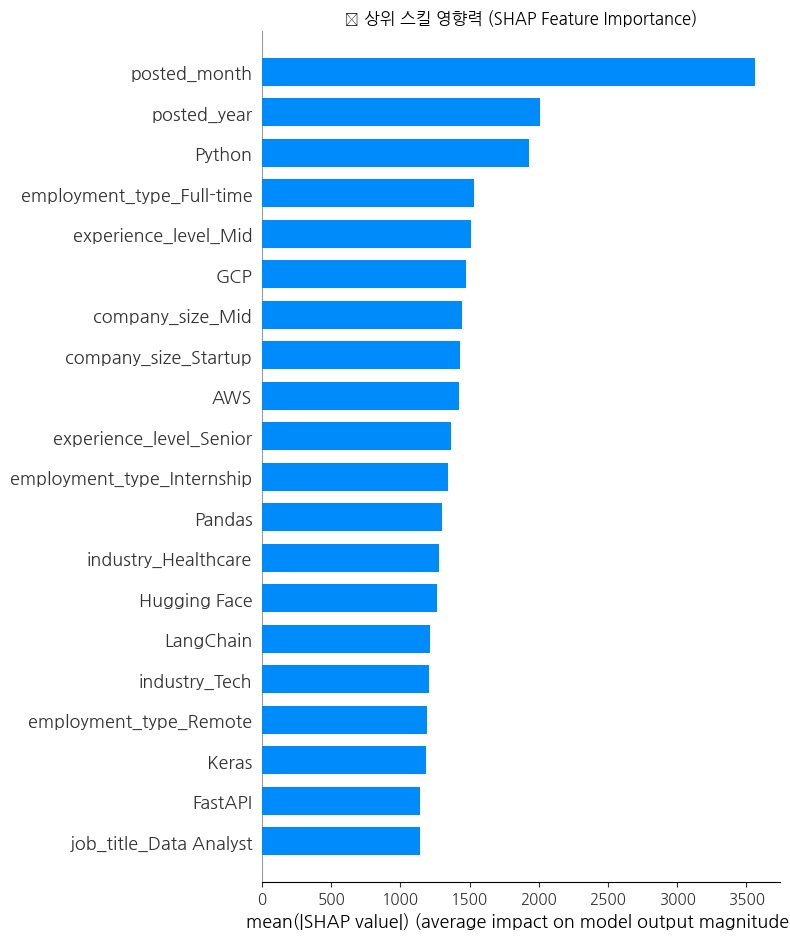

/tmp/ipython-input-3955815224.py:27: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


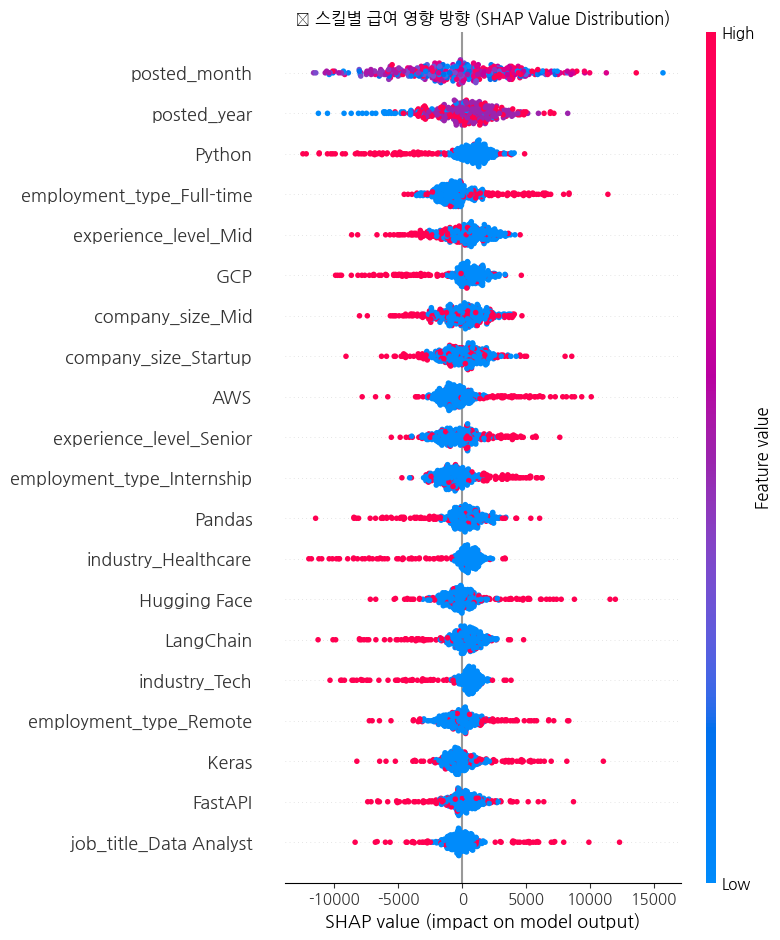

📊 상위 10개 영향력 스킬(또는 스킬 조합):
                      Feature  Mean |SHAP|
43               posted_month  3565.047459
42                posted_year  2008.507184
36                     Python  1931.169877
2   employment_type_Full-time  1534.176762
0        experience_level_Mid  1510.375127
27                        GCP  1473.103054
5            company_size_Mid  1445.001693
6        company_size_Startup  1428.598051
20                        AWS  1421.643177
1     experience_level_Senior  1364.632464


In [131]:
# ======================================
#  SHAP 기반 스킬 영향력 시각화 (LightGBM)
# ======================================

!pip install shap

import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. TreeExplainer 초기화 (LightGBM 전용)
explainer = shap.TreeExplainer(model)

# 2. SHAP 값 계산 (검증 세트 기준)
shap_values = explainer.shap_values(X_test)

# 3. 전체 중요도 요약 그래프
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("📈 상위 스킬 영향력 (SHAP Feature Importance)")
plt.tight_layout()
plt.show()

# 4. 세부 분포 그래프 (값의 방향까지 표시)
shap.summary_plot(shap_values, X_test, show=False)
plt.title("🎯 스킬별 급여 영향 방향 (SHAP Value Distribution)")
plt.tight_layout()
plt.show()

# 5. 상위 10개 중요 스킬 조합(또는 피처) 추출
mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean |SHAP|': mean_abs_shap
}).sort_values('Mean |SHAP|', ascending=False).head(10)

print("📊 상위 10개 영향력 스킬(또는 스킬 조합):")
print(importance_df)


In [132]:
print(df.info())
min, max = 90000, 90000
for a in df['salary_range_usd']:
    if a > max:
        max = a
    if a <min:
        min= a

print(min, max)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   salary_range_usd                    2000 non-null   int64
 1   experience_level_Mid                2000 non-null   int64
 2   experience_level_Senior             2000 non-null   int64
 3   employment_type_Full-time           2000 non-null   int64
 4   employment_type_Internship          2000 non-null   int64
 5   employment_type_Remote              2000 non-null   int64
 6   company_size_Mid                    2000 non-null   int64
 7   company_size_Startup                2000 non-null   int64
 8   industry_E-commerce                 2000 non-null   int64
 9   industry_Education                  2000 non-null   int64
 10  industry_Finance                    2000 non-null   int64
 11  industry_Healthcare                 2000 non-null   int64
 12  indust

In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 분석 대상 스킬 선정 (상위 SHAP 기반 예시)
top_skills = ["Python", "SQL", "AWS"]  # SHAP에서 높은 영향으로 나온 스킬

# 각 스킬별 여부 확인
for skill in top_skills:
    if skill not in df.columns:
        print(f"⚠️ {skill} 컬럼이 존재하지 않습니다.")
    else:
        print(f"✅ {skill} 컬럼 사용 가능")

# 조합 스킬 정의 (예: Python & SQL)
df["combo_Python_SQL"] = ((df["Python"] == 1) & (df["SQL"] == 1)).astype(int)
df["combo_Python_AWS"] = ((df["Python"] == 1) & (df["AWS"] == 1)).astype(int)
df["combo_SQL_AWS"] = ((df["SQL"] == 1) & (df["AWS"] == 1)).astype(int)

# 급여 로그값 or 원급여 사용
target_col = "salary_range_usd" if "salary_range_usd" in df.columns else "salary_log"

# 1. 단일 스킬별 급여 비교
plt.figure(figsize=(10,5))
sns.boxplot(data=df.melt(id_vars=target_col, value_vars=top_skills),
            x="variable", y=target_col, hue="value", palette="Set2")
plt.title("💰 개별 스킬 보유 여부에 따른 급여 분포")
plt.ylabel("Salary (log-scale or USD)")
plt.xlabel("Skill")
plt.legend(title="보유 여부", labels=["없음", "있음"])
plt.tight_layout()
plt.show()

# 2. 조합 스킬별 급여 비교
combos = ["combo_Python_SQL", "combo_Python_AWS", "combo_SQL_AWS"]

plt.figure(figsize=(10,5))
sns.boxplot(data=df.melt(id_vars=target_col, value_vars=combos),
            x="variable", y=target_col, hue="value", palette="Set3")
plt.title("⚙️ 주요 스킬 조합별 급여 분포 비교")
plt.ylabel("Salary (log-scale or USD)")
plt.xlabel("Skill Combination")
plt.legend(title="조합 보유 여부", labels=["없음", "있음"])
plt.tight_layout()
plt.show()

# 3. 조합별 평균 급여 비교
mean_salary = (
    df.groupby(combos)[target_col]
      .mean()
      .reset_index()
      .sort_values(by=target_col, ascending=False)
)
print("📊 스킬 조합별 평균 급여:")
print(mean_salary)


삭제된 컬럼 수: 8
삭제된 컬럼 예시: ['job_title_AI Researcher', 'job_title_Computer Vision Engineer', 'job_title_Data Analyst', 'job_title_Data Scientist', 'job_title_ML Engineer', 'job_title_NLP Engineer', 'job_title_Quant Researcher', 'posted_month']
삭제된 컬럼 수: 2
삭제된 컬럼 예시: ['experience_level_Mid', 'experience_level_Senior']
삭제된 컬럼 수: 3
삭제된 컬럼 예시: ['employment_type_Full-time', 'employment_type_Internship', 'employment_type_Remote']
삭제된 컬럼 수: 2
삭제된 컬럼 예시: ['company_size_Mid', 'company_size_Startup']
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 95654.005625

모델 평가 결과:
RMSE: 38,0

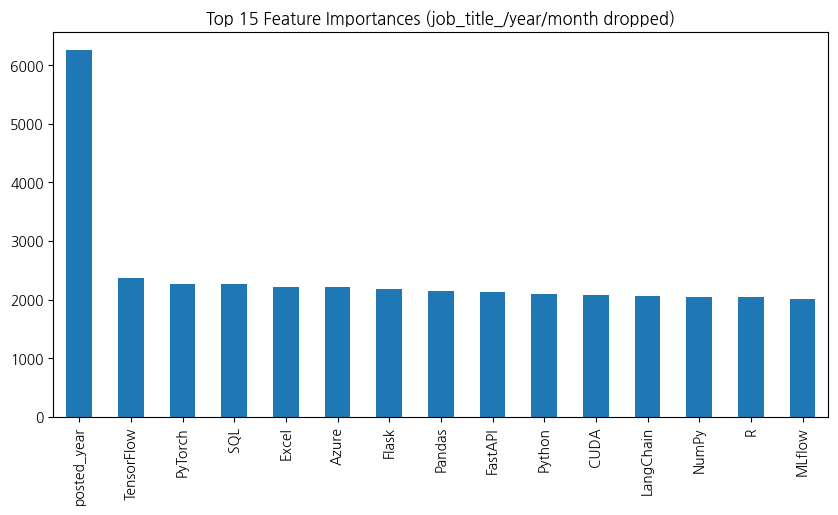


실제 급여 vs 예측 급여 (상위 5개):
   salary_range_usd    pred_salary
0             92860   86990.642274
1             78523   83563.977070
2            124496  123424.086523
3             50908   57001.980512
4             98694   94796.237627


In [152]:
# -----------------------------
# 1. 라이브러리
# -----------------------------
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -----------------------------
# 2. 데이터 불러오기
# -----------------------------
df = pd.read_csv("/content/ai_job_market_preprocessed.csv")

# -----------------------------
# 3. job_title_, posted_year, posted_month 컬럼 자동 삭제
# -----------------------------
# 1) job_title_로 시작하는 모든 컬럼 찾기
drop_cols = [c for c in df.columns if c.startswith("job_title_")]
drop_cols1 = [c for c in df.columns if c.startswith("experience_level_")]
drop_cols2 = [c for c in df.columns if c.startswith("employment_type_")]
drop_cols3 = [c for c in df.columns if c.startswith("company_size_")]
# 2) posted_year, posted_month 명시적 추가
for col in ["posted_month"]:
    if col in df.columns:
        drop_cols.append(col)

# 3) 실제 삭제
print(f"삭제된 컬럼 수: {len(drop_cols)}")
print(f"삭제된 컬럼 예시: {drop_cols[:8]}")  # 일부 예시 출력

df = df.drop(columns=drop_cols, errors='ignore')

# 3) 실제 삭제
print(f"삭제된 컬럼 수: {len(drop_cols1)}")
print(f"삭제된 컬럼 예시: {drop_cols1[:8]}")  # 일부 예시 출력

df = df.drop(columns=drop_cols1, errors='ignore')

# 3) 실제 삭제
print(f"삭제된 컬럼 수: {len(drop_cols2)}")
print(f"삭제된 컬럼 예시: {drop_cols2[:8]}")  # 일부 예시 출력

df = df.drop(columns=drop_cols2, errors='ignore')

# 3) 실제 삭제
print(f"삭제된 컬럼 수: {len(drop_cols3)}")
print(f"삭제된 컬럼 예시: {drop_cols3[:8]}")  # 일부 예시 출력

df = df.drop(columns=drop_cols3, errors='ignore')

# -----------------------------
# 4. 입력(X), 타깃(y) 분리
# -----------------------------
target_col = "salary_range_usd"
X = df.drop(columns=[target_col])
y = df[target_col]

# -----------------------------
# 5. 데이터 분할
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 6. 모델 정의 및 학습
# -----------------------------
model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.85,
    random_state=42
)
model.fit(X_train, y_train)

# -----------------------------
# 7. 평가
# -----------------------------
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n모델 평가 결과:")
print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

# -----------------------------
# 8. 주요 스킬 중요도 시각화
# -----------------------------
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,5))
importances.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances (job_title_/year/month dropped)")
plt.show()

# -----------------------------
# 9. 예측값 추가 및 미리보기
# -----------------------------
df["pred_salary"] = model.predict(X)
print("\n실제 급여 vs 예측 급여 (상위 5개):")
print(df[[target_col, "pred_salary"]].head())


In [1]:
from graphviz import Digraph

# ERD 그래프 생성
erd = Digraph('AI_JobMarket_ERD', filename='ai_job_market_erd', format='png')
erd.attr(rankdir='LR', size='8,5')  # 가로형 배치

# 엔티티 노드 정의
erd.attr('node', shape='box', style='filled', fillcolor='#EFF3FF', color='#5A78C6', fontname='NanumGothic')
erd.node('JobPosting', 'JobPosting\n- salary_range_usd\n- posted_year\n- posted_month')

erd.node('ExperienceLevel', 'ExperienceLevel\n- Mid\n- Senior')
erd.node('EmploymentType', 'EmploymentType\n- Full-time\n- Remote\n- Internship')
erd.node('Industry', 'Industry\n- Tech\n- Education\n- Finance...')
erd.node('JobTitle', 'JobTitle\n- ML Engineer\n- Data Scientist\n- Data Analyst...')
erd.node('Skill', 'Skill\n- Python\n- SQL\n- TensorFlow\n- PyTorch...')

# 관계 연결선
erd.attr('edge', color='#4A5568', arrowsize='0.7')
erd.edge('JobPosting', 'ExperienceLevel', label='1:N')
erd.edge('JobPosting', 'EmploymentType', label='1:N')
erd.edge('JobPosting', 'Industry', label='1:N')
erd.edge('JobPosting', 'JobTitle', label='1:N')
erd.edge('JobPosting', 'Skill', label='N:N')

# 파일 저장 및 렌더링
erd.render()
print("✅ ERD 다이어그램이 'ai_job_market_erd.png'로 생성되었습니다.")


✅ ERD 다이어그램이 'ai_job_market_erd.png'로 생성되었습니다.
